#CARGA DE DATOS

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


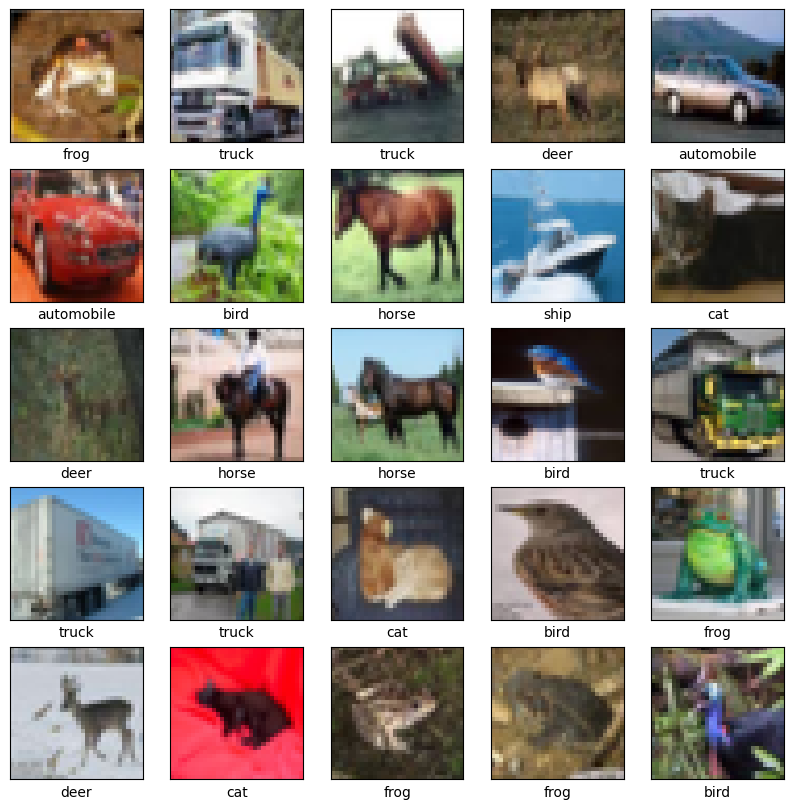

Forma de las imágenes de entrenamiento: (50000, 32, 32, 3)
Forma de las etiquetas de entrenamiento: (50000, 1)
Forma de las imágenes de prueba: (10000, 32, 32, 3)
Forma de las etiquetas de prueba: (10000, 1)


In [2]:

# Cargar el dataset CIFAR-10
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalizar los valores de los píxeles a un rango de [0, 1]
# Esto es crucial para el entrenamiento de redes neuronales.
train_images, test_images = train_images / 255.0, test_images / 255.0

# Nombres de las clases para visualización
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Visualizar algunas imágenes (Opcional, pero recomendado)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # Reajustamos train_images[i] si es necesario (Keras ya lo maneja bien)
    plt.imshow(train_images[i])
    # La etiqueta está en formato de array, tomamos el primer elemento [0]
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

print(f"Forma de las imágenes de entrenamiento: {train_images.shape}")
print(f"Forma de las etiquetas de entrenamiento: {train_labels.shape}")
print(f"Forma de las imágenes de prueba: {test_images.shape}")
print(f"Forma de las etiquetas de prueba: {test_labels.shape}")

Descripción: Contiene 60,000 imágenes de color (32x32 píxeles) en 10 clases, con 6,000 imágenes por clase.

- Clases: avión, automóvil, pájaro, gato, ciervo, perro, rana, caballo, barco, camión.

#BASELANE

In [3]:
# 1. Crear el modelo secuencial
model = models.Sequential()

# 2. Primera capa convolucional y de pooling
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# 3. Segunda capa convolucional y de pooling
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# 4. Tercera capa convolucional (opcional, pero ayuda a la complejidad)
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# 5. Capas densas (Clasificador)
# Aplanar la salida de las capas convolucionales (de 3D a 1D)
model.add(layers.Flatten())
# Capa densa con 64 neuronas
model.add(layers.Dense(64, activation='relu'))
# Capa de salida con 10 neuronas (una por clase) y activación softmax
model.add(layers.Dense(10, activation='softmax'))

# Resumen de la arquitectura del modelo
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# --- 3.1 Configuración para guardar los mejores pesos ---
# Ruta donde se guardará el archivo .h5
checkpoint_filepath = 'cifar10_baseline_best_weights.weights.h5'

# Creamos la carpeta (si es necesario) en Colab
# os.makedirs(os.path.dirname(checkpoint_filepath), exist_ok=True)

# Definición del Callback
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',      # Monitorea la precisión en los datos de prueba/validación
    mode='max',                  # Buscamos maximizar la métrica
    save_best_only=True,         # ¡Solo guarda si es el mejor rendimiento hasta ahora!
    save_weights_only=True,      # Guarda solo los pesos, no el modelo completo
    verbose=1                    # Muestra un mensaje cuando guarda
)

# --- 3.2 Compilación y Entrenamiento del Modelo ---
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Entrenar el modelo, ahora con el callback
print("\nIniciando entrenamiento...")
history = model.fit(
    train_images,
    train_labels,
    epochs=50, # Usaremos 20 épocas para este baseline
    validation_data=(test_images, test_labels),
    callbacks=[model_checkpoint_callback] # Pasamos el callback
)


Iniciando entrenamiento...
Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3491 - loss: 1.7616
Epoch 1: val_accuracy improved from -inf to 0.54540, saving model to cifar10_baseline_best_weights.weights.h5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.3492 - loss: 1.7614 - val_accuracy: 0.5454 - val_loss: 1.2684
Epoch 2/50
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5556 - loss: 1.2477
Epoch 2: val_accuracy improved from 0.54540 to 0.60370, saving model to cifar10_baseline_best_weights.weights.h5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5556 - loss: 1.2476 - val_accuracy: 0.6037 - val_loss: 1.1052
Epoch 3/50
1561/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6152 - loss: 1.0853
Epoch 3: val_accuracy improved from 0.60370 to 0.60440, saving model to cifar10_baseline_best_weights.weights.h5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6152 - loss: 1.0853 - val_accuracy: 0.6044 - val_loss: 1.1336
Epoch 4/50
155

In [14]:
# --- 4.1 Cargar los mejores pesos guardados ---
try:
    # Si el archivo se guardó correctamente, cárgalo
    model.load_weights(checkpoint_filepath)
    print(f"\n✅ Pesos cargados exitosamente desde: {checkpoint_filepath}")
except:
    print("\n⚠️ Advertencia: No se pudo cargar el archivo de pesos. Se usará el modelo final de la última época.")

# --- 4.2 Evaluación Final del Baseline ---
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print(f"\n🚀 Precisión FINAL del BASELINE (con mejores pesos): {test_acc*100:.2f}%")


✅ Pesos cargados exitosamente desde: cifar10_baseline_best_weights.weights.h5
313/313 - 1s - 2ms/step - accuracy: 0.7161 - loss: 0.8902

🚀 Precisión FINAL del BASELINE (con mejores pesos): 71.61%


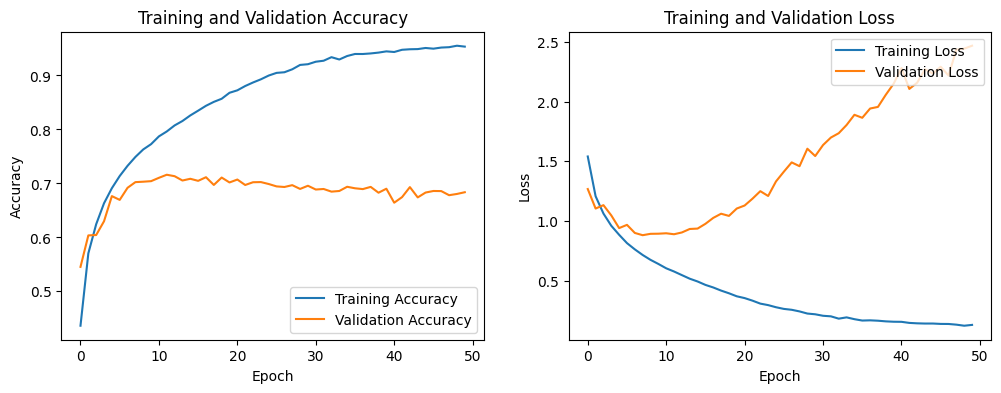

In [15]:
# 2. Visualizar el historial de entrenamiento (Opcional)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#FASE DOS

In [6]:
# Cargar y Normalizar el Dataset CIFAR-10
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

# Ruta para guardar el modelo mejorado
checkpoint_filepath_fase2 = 'cifar10_improved_best_weights.weights.h5'

#DEFINICIÓN DEL MODELO MEJORADO

In [7]:
# --- 1. Definición de Data Augmentation y Modelo ---
input_shape = train_images.shape[1:] # (32, 32, 3)

# Definición de la Capa de Data Augmentation
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ],
    # Nombre para identificarla en el summary
    name="data_augmentation"
)

model_fase2 = models.Sequential()
# Solución: Pasar el input_shape a la primera capa (Data Augmentation)
model_fase2.add(data_augmentation)
model_fase2.build(input_shape=(None, *input_shape)) # Esto fuerza la construcción del modelo

# --- Arquitectura Mejorada (Fase 2) ---
model_fase2.add(layers.Conv2D(64, (3, 3), padding='same'))
model_fase2.add(layers.BatchNormalization())
model_fase2.add(layers.Activation('relu'))
model_fase2.add(layers.MaxPooling2D((2, 2)))

model_fase2.add(layers.Conv2D(128, (3, 3), padding='same'))
model_fase2.add(layers.BatchNormalization())
model_fase2.add(layers.Activation('relu'))
model_fase2.add(layers.MaxPooling2D((2, 2)))

model_fase2.add(layers.Conv2D(128, (3, 3), padding='same'))
model_fase2.add(layers.BatchNormalization())
model_fase2.add(layers.Activation('relu'))

model_fase2.add(layers.Flatten())
model_fase2.add(layers.Dropout(0.25))
model_fase2.add(layers.Dense(256, activation='relu'))
model_fase2.add(layers.Dropout(0.25))
model_fase2.add(layers.Dense(10, activation='softmax'))

# Muestra el summary corregido
print("--- Resumen del Modelo Fase 2 ---")
model_fase2.summary()

--- Resumen del Modelo Fase 2 ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,324,490 (8.87 MB)

 Trainable params: 2,323,850 (8.86 MB)

 Non-trainable params: 640 (2.50 KB)

In [18]:
# --- 3.1 Configuración para guardar los mejores pesos ---
model_checkpoint_callback_fase2 = ModelCheckpoint(
    filepath=checkpoint_filepath_fase2,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# --- 3.2 Compilación y Entrenamiento del Modelo ---
model_fase2.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'])

print("\nIniciando entrenamiento del Modelo MEJORADO (Fase Dos) por 50 épocas...")

# Entrenar el modelo, ahora con el callback
history_fase2 = model_fase2.fit(
    train_images,
    train_labels,
    epochs=50,
    batch_size=64,
    validation_data=(test_images, test_labels),
    callbacks=[model_checkpoint_callback_fase2]
)


Iniciando entrenamiento del Modelo MEJORADO (Fase Dos) por 50 épocas...
Epoch 1/50
779/782 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3264 - loss: 1.9760
Epoch 1: val_accuracy improved from -inf to 0.47800, saving model to cifar10_improved_best_weights.weights.h5
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.3268 - loss: 1.9746 - val_accuracy: 0.4780 - val_loss: 1.4803
Epoch 2/50
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4686 - loss: 1.4517
Epoch 2: val_accuracy did not improve from 0.47800
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.4687 - loss: 1.4515 - val_accuracy: 0.4462 - val_loss: 1.5540
Epoch 3/50
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5256 - loss: 1.3198
Epoch 3: val_accuracy improved from 0.47800 to 0.50220, saving model to cifar10_improved_best_weights.weights.h5
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.5256 - loss: 1.3197 - val_accuracy: 0.5022 - val_loss: 1.3954
Epoch 4/50
780/782 ━━━━━━━━━━━━━━━━

In [19]:
# --- 3. Carga y Evaluación Final ---

# Cargar los mejores pesos guardados
try:
    model_fase2.load_weights(checkpoint_filepath_fase2)
    print(f"\n✅ Pesos cargados exitosamente desde: {checkpoint_filepath_fase2}")
except Exception as e:
    print(f"\n⚠️ Advertencia: No se pudo cargar el archivo de pesos. Usando el modelo de la última época. Error: {e}")

# Evaluación Final del Modelo Mejorado
test_loss_fase2, test_acc_fase2 = model_fase2.evaluate(test_images,  test_labels, verbose=2)

print(f"\n🚀 Precisión FINAL del BASELINE (Fase Uno): 71.13%")
print(f"🌟 Precisión FINAL del MEJORADO (Fase Dos): {test_acc_fase2*100:.2f}%")


✅ Pesos cargados exitosamente desde: cifar10_improved_best_weights.weights.h5
313/313 - 1s - 4ms/step - accuracy: 0.8074 - loss: 0.5790

🚀 Precisión FINAL del BASELINE (Fase Uno): 71.13%
🌟 Precisión FINAL del MEJORADO (Fase Dos): 80.74%


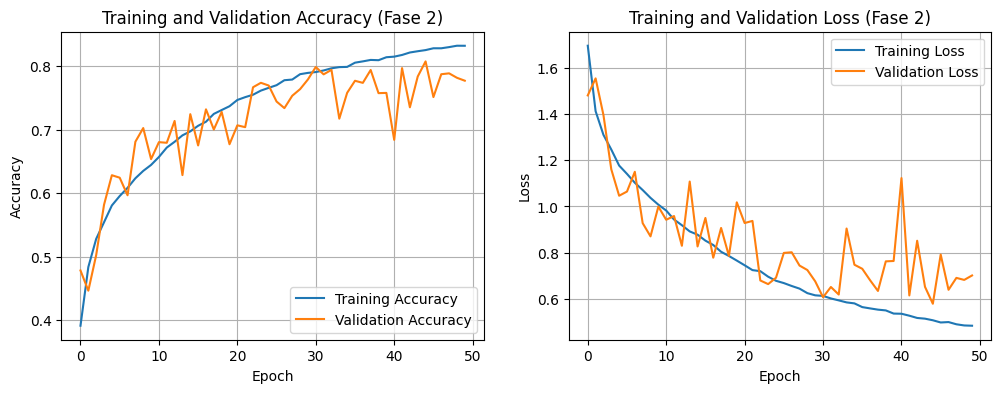

In [20]:
# --- 4. Visualización del Historial de Entrenamiento de la Fase 2 ---
plt.figure(figsize=(12, 4))

# 4.1 Plot de Precisión
plt.subplot(1, 2, 1)
plt.plot(history_fase2.history['accuracy'], label='Training Accuracy')
plt.plot(history_fase2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Fase 2)')
plt.grid(True)

# 4.2 Plot de Pérdida (Loss)
plt.subplot(1, 2, 2)
plt.plot(history_fase2.history['loss'], label='Training Loss')
plt.plot(history_fase2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Fase 2)')
plt.grid(True)

plt.show()

#RESNET

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

# Cargar y Normalizar el Dataset CIFAR-10
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

# Ruta para guardar los pesos del modelo ResNet
checkpoint_filepath_resnet = 'cifar10_resnet_best_weights.weights.h5'

##Bloque residual

In [10]:
# --- Bloque Residual Consistente (Adaptado) ---
def residual_block(x, filters, stride=1):
    # Definimos el atajo (shortcut)
    shortcut = x

    # --- Rama Principal ---
    # Primera convolución (puede incluir downsampling si stride=2)
    x = layers.Conv2D(filters, 3, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Segunda convolución
    x = layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # --- Ajuste del Atajo (Shortcut) ---
    # Si el atajo necesita cambiar de dimensión (por stride > 1 o cambio de filtros)
    if stride != 1 or shortcut.shape[-1] != filters:
        # Usar una convolución 1x1 con el mismo stride para ajustar
        shortcut = layers.Conv2D(filters, 1, strides=stride, use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # --- Suma Residual ---
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

##ResNet senciilla

In [11]:
# Definición de la ResNet-18 Light para CIFAR-10
def create_resnet_cifar10():
    input_tensor = layers.Input(shape=(32, 32, 3))

    # 1. Capa de entrada inicial
    x = layers.Conv2D(64, 3, padding='same', use_bias=False)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # --- Etapa 1: 64 Filtros (32x32) ---
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    # --- Etapa 2: 128 Filtros (Downsampling a 16x16) ---
    # Primer bloque: Cambia de 64 a 128 filtros y hace downsampling (stride=2)
    x = residual_block(x, 128, stride=2)
    # Segundo bloque: Solo 128 filtros (stride=1)
    x = residual_block(x, 128)

    # --- Etapa 3: 256 Filtros (Downsampling a 8x8) ---
    # Primer bloque: Cambia de 128 a 256 filtros y hace downsampling (stride=2)
    x = residual_block(x, 256, stride=2) # El error se produjo aquí anteriormente si no se usaba un bloque que adaptara.
    # Segundo bloque: Solo 256 filtros (stride=1)
    x = residual_block(x, 256)

    # --- Clasificador ---
    x = layers.GlobalAveragePooling2D()(x) # Reduce a un vector (1x1x256)
    x = layers.Dense(10, activation='softmax')(x)

    model = models.Model(inputs=input_tensor, outputs=x)
    return model

model_resnet = create_resnet_cifar10()
model_resnet.summary()

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │      1,728 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │     36,864 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │     36,864 │ activation_4[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │     36,864 │ activation_5[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32,    │     36,864 │ activation_6[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 2,782,154 (10.61 MB)

 Trainable params: 2,777,674 (10.60 MB)

 Non-trainable params: 4,480 (17.50 KB)

##ENtrenamiento y evaluación


In [24]:
# --- 4.1 Configuración para guardar los mejores pesos ---
model_checkpoint_callback_resnet = ModelCheckpoint(
    filepath=checkpoint_filepath_resnet,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# --- 4.2 Compilación y Entrenamiento ---
# Usaremos un optimizador con tasa de aprendizaje más lenta para una red más profunda
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_resnet.compile(optimizer=optimizer,
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'])

print("\nIniciando entrenamiento del Modelo RESIDUAL (Fase Tres) por 50 épocas...")

history_resnet = model_resnet.fit(
    train_images,
    train_labels,
    epochs=50,
    batch_size=64,
    validation_data=(test_images, test_labels),
    callbacks=[model_checkpoint_callback_resnet]
)



Iniciando entrenamiento del Modelo RESIDUAL (Fase Tres) por 50 épocas...
Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4584 - loss: 1.5218
Epoch 1: val_accuracy improved from -inf to 0.47730, saving model to cifar10_resnet_best_weights.weights.h5
782/782 ━━━━━━━━━━━━━━━━━━━━ 57s 54ms/step - accuracy: 0.4586 - loss: 1.5214 - val_accuracy: 0.4773 - val_loss: 1.7466
Epoch 2/50
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7115 - loss: 0.8247
Epoch 2: val_accuracy improved from 0.47730 to 0.58810, saving model to cifar10_resnet_best_weights.weights.h5
782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.7116 - loss: 0.8246 - val_accuracy: 0.5881 - val_loss: 1.4208
Epoch 3/50
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7900 - loss: 0.6002
Epoch 3: val_accuracy improved from 0.58810 to 0.70510, saving model to cifar10_resnet_best_weights.weights.h5
782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.7901 - loss: 0.6001 - val_accuracy: 0.70

In [25]:

# --- 4.3 Evaluación Final ---
try:
    model_resnet.load_weights(checkpoint_filepath_resnet)
    print(f"\n✅ Pesos cargados exitosamente desde: {checkpoint_filepath_resnet}")
except Exception as e:
    print(f"\n⚠️ Advertencia: No se pudo cargar el archivo de pesos. Usando el modelo de la última época. Error: {e}")

test_loss_resnet, test_acc_resnet = model_resnet.evaluate(test_images,  test_labels, verbose=2)

print(f"\n🚀 Precisión FINAL del MEJORADO (Fase Dos): 81.28%")
print(f"🌟 Precisión FINAL del RESNET (Fase Tres): {test_acc_resnet*100:.2f}%")


✅ Pesos cargados exitosamente desde: cifar10_resnet_best_weights.weights.h5
313/313 - 3s - 11ms/step - accuracy: 0.8545 - loss: 0.8316

🚀 Precisión FINAL del MEJORADO (Fase Dos): 81.28%
🌟 Precisión FINAL del RESNET (Fase Tres): 85.45%


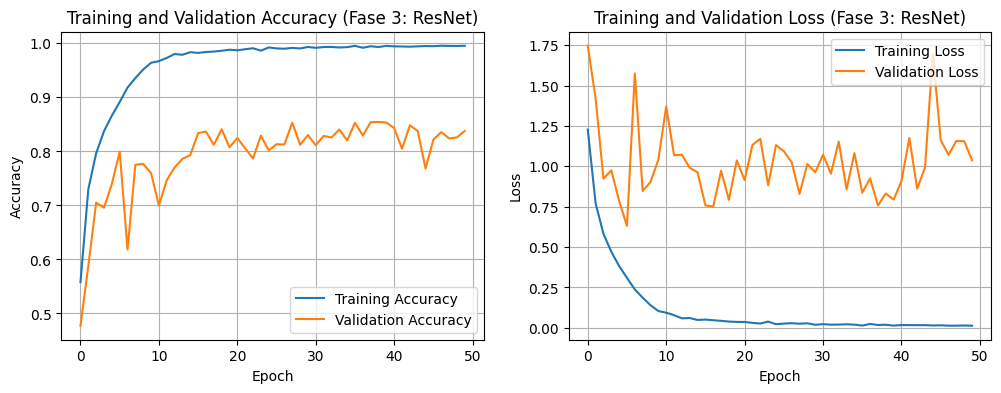

In [26]:
import matplotlib.pyplot as plt

# --- Visualización del Historial de Entrenamiento de la Fase 3 (ResNet) ---
plt.figure(figsize=(12, 4))

# 1. Plot de Precisión
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Fase 3: ResNet)')
plt.grid(True)

# 2. Plot de Pérdida (Loss)
plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Training Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Fase 3: ResNet)')
plt.grid(True)

plt.show()